**Write the names of all group members (max. 5 members)**:
- Hugo Belzil-
- Célestin Hans
- Côme Blanc

When submitting your work, please follow closely the template below.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.linear_model import PoissonRegressor
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [25]:
SEED = 42

# Exercise 1 (Poisson GLM)

### Question 1.a

In [26]:
data = pd.read_csv('freMTPL2freq.csv', delimiter=';')
print(data.head(70))

target_col = 'ClaimNb'
exposure_col = 'Exposure'

# The column Exposure was encoded with commas instead of columns (French!!!)
data[exposure_col] = data[exposure_col].astype(str).str.replace(',', '.', regex=False).astype(float)

feature_cols = [c for c in data.columns if c not in [target_col, exposure_col]]

x = data[feature_cols]
claims = data[target_col]
exposure = data[exposure_col]

    VehPower  VehAge  DrivAge  BonusMalus VehBrand   VehGas  Density Region  \
0          4       9       23         100       B6  Regular     7887    R31   
1          4       6       26         100       B6  Regular     2308    R31   
2          4       6       26         100       B6  Regular     2308    R31   
3          7       4       44          50       B6  Regular       37    R94   
4          5       2       29          90       B6  Regular      335    R91   
..       ...     ...      ...         ...      ...      ...      ...    ...   
65         6       2       71          54       B6  Regular     1541    R91   
66         8       9       56          50       B6   Diesel      272    R72   
67         5       3       52          50       B6  Regular      214    R26   
68         5       3       52          50       B6  Regular      214    R26   
69         5       6       40          60       B6  Regular    15703    R11   

   Exposure  ClaimNb  
0      0,76        0  
1    

In [27]:
# Train test split
x_train, x_test, claims_train, claims_test, exp_train, exp_test = train_test_split(
    x, claims, exposure,
    test_size=0.1,
    random_state=SEED
)

# Obtaining categorical columns and printing them
categoric_columns = x.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = [c for c in x.columns if c not in categoric_columns]

print('Categoric columns in the dataset : ', categoric_columns, '\n')
print('Numerical columns in the dataset : ', num_cols)

# One-Hot encoding of data
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe.fit(x_train[categoric_columns])

X_train_cat = ohe.transform(x_train[categoric_columns])
X_test_cat  = ohe.transform(x_test[categoric_columns])

# Scaling numerical variables
scaler_x = StandardScaler()
scaler_x.fit(x_train[num_cols])

X_train_num = scaler_x.transform(x_train[num_cols])
X_test_num  = scaler_x.transform(x_test[num_cols])

# Final design matrices
X_train_enc = np.hstack([X_train_num, X_train_cat])
X_test_enc  = np.hstack([X_test_num, X_test_cat])

y_train = claims_train / exp_train
y_test  = claims_test / exp_test

model_PR = PoissonRegressor(alpha=0, fit_intercept=True)
model_PR.fit(X_train_enc, y_train, sample_weight=exp_train)

y_pred_train = model_PR.predict(X_train_enc)
y_pred_test  = model_PR.predict(X_test_enc)

# Exposure-weighted Poisson deviance (Equation 2)
def weighted_poisson_deviance(y_true, y_pred, exposure):
    # Numerical stability
    
    y_pred = np.clip(y_pred, 1e-15, None)
    y_true_safe = np.where(y_true > 0, y_true, 1.0)

    deviance = 2 * (
        y_pred - y_true
        - y_true * np.log(y_pred)
        + y_true * np.log(y_true_safe)
    )

   
    deviance = np.where(y_true > 0, deviance, 2 * y_pred)

    return np.sum(exposure * deviance) / np.sum(exposure)

mae_train = mean_absolute_error(y_train, y_pred_train, sample_weight=exp_train)
mse_train = mean_squared_error(y_train, y_pred_train, sample_weight=exp_train)
loss_train = weighted_poisson_deviance(y_train, y_pred_train, exp_train)

mae_test = mean_absolute_error(y_test, y_pred_test, sample_weight=exp_test)
mse_test = mean_squared_error(y_test, y_pred_test, sample_weight=exp_test)
loss_test = weighted_poisson_deviance(y_test, y_pred_test, exp_test)

print('\n--- Question 1.a: Basic Poisson GLM ---')
print(f'Train set - MAE: {mae_train:.5f}, MSE: {mse_train:.5f}, Loss L: {loss_train:.5f}')
print(f'Test set  - MAE: {mae_test:.5f}, MSE: {mse_test:.5f}, Loss L: {loss_test:.5f}')

Categoric columns in the dataset :  ['VehBrand', 'VehGas', 'Region'] 

Numerical columns in the dataset :  ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']

--- Question 1.a: Basic Poisson GLM ---
Train set - MAE: 0.13828, MSE: 0.23555, Loss L: 0.45911
Test set  - MAE: 0.13631, MSE: 0.25534, Loss L: 0.45070


### Question 1.b

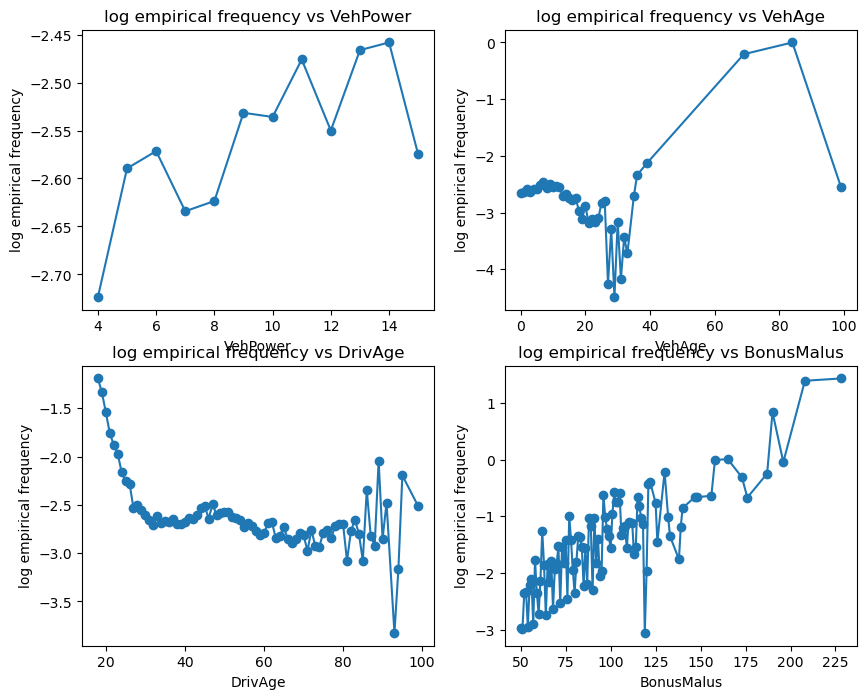

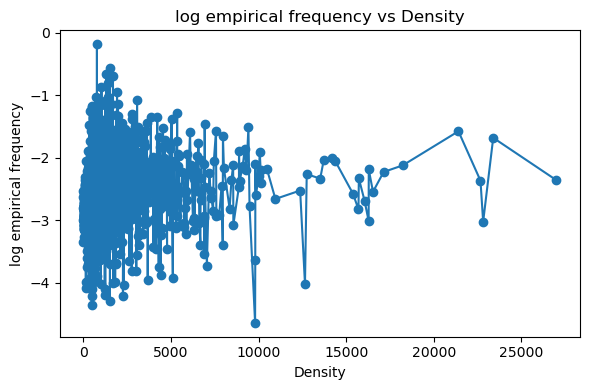

<Figure size 640x480 with 0 Axes>

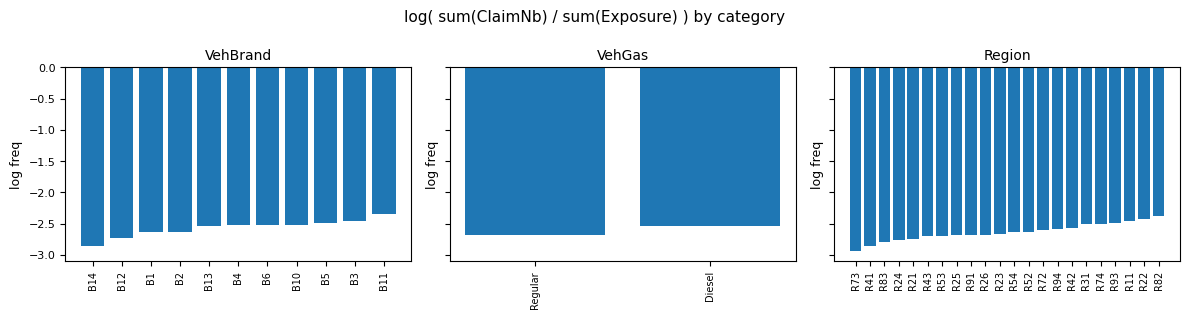

In [28]:
# plotting discrete features figures
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()   # easier indexing: axes[0], ..., axes[3]

for i, col in enumerate(num_cols):
    unique_vals = np.sort(data[col].unique())

    x_vals = []
    log_freq_vals = []

    for v in unique_vals:
        mask = (data[col] == v)
        total_claims = data.loc[mask, "ClaimNb"].sum()
        total_exposure = data.loc[mask, "Exposure"].sum()

        if total_exposure <= 1e-6:
            continue

        lam_hat = total_claims / total_exposure
        if lam_hat <= 0:
            continue

        x_vals.append(v)
        log_freq_vals.append(np.log(lam_hat))

    if i < 4:
        ax = axes[i]
        ax.plot(x_vals, log_freq_vals, marker="o")
        ax.set_xlabel(col)
        ax.set_ylabel("log empirical frequency")
        ax.set_title(f"log empirical frequency vs {col}")
    else:
        plt.figure(figsize=(6, 4))
        plt.plot(x_vals, log_freq_vals, marker="o")
        plt.xlabel(col)
        plt.ylabel("log empirical frequency")
        plt.title(f"log empirical frequency vs {col}")
        plt.tight_layout()
        plt.show()

plt.tight_layout()
plt.show()

def plot_logfreq_by_category(ax, df, cat_col, claim_col="ClaimNb", exp_col="Exposure",
                             min_total_exposure=100.0, eps=1e-12, top_n=None):
    g = (df.groupby(cat_col, observed=True)[[claim_col, exp_col]]
           .sum()
           .rename(columns={claim_col: "claims", exp_col: "exposure"}))

    g = g[g["exposure"] >= min_total_exposure].copy()
    g["log_freq"] = np.log((g["claims"] + eps) / (g["exposure"] + eps))
    g = g.sort_values("log_freq")

    if top_n is not None and len(g) > top_n:
        g = pd.concat([g.head(top_n//2), g.tail(top_n - top_n//2)])

    ax.bar(g.index.astype(str), g["log_freq"].to_numpy())
    ax.set_title(cat_col, fontsize=10)
    ax.tick_params(axis="x", labelrotation=90, labelsize=7)
    ax.tick_params(axis="y", labelsize=8)
    ax.set_ylabel("log freq", fontsize=9)

fig, axes = plt.subplots(1, 3, figsize=(12, 3.2), sharey=True)

plot_logfreq_by_category(axes[0], data, "VehBrand", min_total_exposure=200.0, top_n=30)
plot_logfreq_by_category(axes[1], data, "VehGas",   min_total_exposure=200.0)
plot_logfreq_by_category(axes[2], data, "Region",   min_total_exposure=200.0, top_n=40)

fig.suptitle("log( sum(ClaimNb) / sum(Exposure) ) by category", fontsize=11)
fig.tight_layout()
plt.show()


### Question 1.c

Looking at the figures above, we decided to categorize the variables 'DrivAge' and 'VehAge', because they both exhibit a clear complex non-linear trend (no obvious transformation appear to us in order to make them linear, thus we categorize). However, the variable BonusMalus seems to follow a linear trend, and so does the variable 'VehiculePower' in a less important way, so we don't transform these two.

In [29]:
# Propose feature transformations. Justify your choices

# we copy the dataset to distinct it for the feature engineering part
x_fe = x.copy()

# DrivAge as categorical bands
bins   = [18, 22, 26, 36, 51, 66, np.inf]
labels = ["18-21", "22-25", "26-35", "36-50", "51-65", "66+"]

x_fe["DrivAgeCat"] = pd.cut(
    x_fe["DrivAge"],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=False
).astype("category")

x_fe = x_fe.drop(columns=["DrivAge"])

# VehAge as categorical bands
bins   = [0, 1, 5, 10, 20, np.inf]
labels = ["0-1", "2-5", "6-10", "11-20", ">20"]

x_fe["VehAgeCat"] = pd.cut(
    x_fe["VehAge"],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True
).astype("category")

x_fe = x_fe.drop(columns=["VehAge"])

# Train-test split (note x_fe instead of x)
# warning : using the same seed is important here to make sure we compare the losses
# on the same dataset
x_train_fe, x_test_fe, claims_train_fe, claims_test_fe, exp_train_fe, exp_test_fe = train_test_split(
    x_fe, claims, exposure,
    test_size=0.1,
    random_state=SEED # seed
)


categoric_columns_fe = x_train_fe.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols_fe = [c for c in x_train_fe.columns if c not in categoric_columns_fe]

print("Categoric columns in the dataset : ", categoric_columns_fe, "\n")
print("Numerical columns in the dataset : ", num_cols_fe)

ohe_fe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
ohe_fe.fit(x_train_fe[categoric_columns_fe])

X_train_cat_fe = ohe_fe.transform(x_train_fe[categoric_columns_fe])
X_test_cat_fe  = ohe_fe.transform(x_test_fe[categoric_columns_fe])

scaler_x_fe = StandardScaler()
scaler_x_fe.fit(x_train_fe[num_cols_fe])

X_train_num_fe = scaler_x_fe.transform(x_train_fe[num_cols_fe])
X_test_num_fe  = scaler_x_fe.transform(x_test_fe[num_cols_fe])

X_train_enc_fe = np.hstack([X_train_num_fe, X_train_cat_fe])
X_test_enc_fe  = np.hstack([X_test_num_fe, X_test_cat_fe])

y_train_fe = claims_train_fe / exp_train_fe
y_test_fe  = claims_test_fe / exp_test_fe

# Poisson GLM
model_PR_fe = PoissonRegressor(alpha=0, fit_intercept=True)
model_PR_fe.fit(X_train_enc_fe, y_train_fe, sample_weight=exp_train_fe)

y_pred_train_fe = model_PR_fe.predict(X_train_enc_fe)
y_pred_test_fe  = model_PR_fe.predict(X_test_enc_fe)

mae_train_fe = mean_absolute_error(y_train_fe, y_pred_train_fe, sample_weight=exp_train_fe)
mse_train_fe = mean_squared_error(y_train_fe, y_pred_train_fe, sample_weight=exp_train_fe)
loss_train_fe = weighted_poisson_deviance(y_train_fe, y_pred_train_fe, exp_train_fe)

mae_test_fe = mean_absolute_error(y_test_fe, y_pred_test_fe, sample_weight=exp_test_fe)
mse_test_fe = mean_squared_error(y_test_fe, y_pred_test_fe, sample_weight=exp_test_fe)
loss_test_fe = weighted_poisson_deviance(y_test_fe, y_pred_test_fe, exp_test_fe)

print("\n--- Question 1.c: Poisson GLM with feature transformations ---")

# METRICS
if all(name in globals() for name in ["mae_train", "mse_train", "loss_train", "mae_test", "mse_test", "loss_test"]):
    print("Baseline (Q1.a) vs Feature Engineering (Q1.c)\n")

    print(f"Train set - MAE: {mae_train:.5f}  ->  {mae_train_fe:.5f}")
    print(f"Train set - MSE: {mse_train:.5f}  ->  {mse_train_fe:.5f}")
    print(f"Train set - Loss L: {loss_train:.5f}  ->  {loss_train_fe:.5f}\n")

    print(f"Test set  - MAE: {mae_test:.5f}  ->  {mae_test_fe:.5f}")
    print(f"Test set  - MSE: {mse_test:.5f}  ->  {mse_test_fe:.5f}")
    print(f"Test set  - Loss L: {loss_test:.5f}  ->  {loss_test_fe:.5f}")
else:
    # Fallback: just print the feature-engineered metrics
    print(f"Train set - MAE: {mae_train_fe:.5f}, MSE: {mse_train_fe:.5f}, Loss L: {loss_train_fe:.5f}")
    print(f"Test set  - MAE: {mae_test_fe:.5f}, MSE: {mse_test_fe:.5f}, Loss L: {loss_test_fe:.5f}")

# Improvement in weighted Poisson deviance (positive = better, negative = worse)
if all(name in globals() for name in ["loss_train", "loss_test"]):
    dev_impr_train = loss_train - loss_train_fe
    dev_impr_test  = loss_test  - loss_test_fe

    print("\nWeighted deviance improvement (Baseline - FE):")
    print(f"Train: {dev_impr_train:.6f}  ({dev_impr_train/loss_train:+.2%})")
    print(f"Test : {dev_impr_test :.6f}  ({dev_impr_test /loss_test :+.2%})")


Categoric columns in the dataset :  ['VehBrand', 'VehGas', 'Region', 'DrivAgeCat', 'VehAgeCat'] 

Numerical columns in the dataset :  ['VehPower', 'BonusMalus', 'Density']

--- Question 1.c: Poisson GLM with feature transformations ---
Baseline (Q1.a) vs Feature Engineering (Q1.c)

Train set - MAE: 0.13828  ->  0.13818
Train set - MSE: 0.23555  ->  0.23544
Train set - Loss L: 0.45911  ->  0.45831

Test set  - MAE: 0.13631  ->  0.13622
Test set  - MSE: 0.25534  ->  0.25515
Test set  - Loss L: 0.45070  ->  0.44943

Weighted deviance improvement (Baseline - FE):
Train: 0.000808  (+0.18%)
Test : 0.001268  (+0.28%)


# Exercise 2 (Poisson FNN)

### Question 2a)

In this cell below, we implement a somewhat "simple" feed-forward network with 2 hidden layers of size 20, and where the output layer's activation function is the exponential function. In this part, we do not use any regularization technique. We notice that this model is not as good as the baseline GLM but we find a better architecture with certain hyperparameters in the next part to increase the performance.

In [ ]:
# Neural Network implementation

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# converting to tensors (required for PyTorch)
Xtr = torch.tensor(X_train_enc, dtype=torch.float32, device=device)
Xte = torch.tensor(X_test_enc,  dtype=torch.float32, device=device)

ytr = torch.tensor(y_train.to_numpy(), dtype=torch.float32, device=device).view(-1, 1)
yte = torch.tensor(y_test.to_numpy(),  dtype=torch.float32, device=device).view(-1, 1)

wtr = torch.tensor(exp_train.to_numpy(), dtype=torch.float32, device=device).view(-1, 1)
wte = torch.tensor(exp_test.to_numpy(),  dtype=torch.float32, device=device).view(-1, 1)

def exposure_weighted_poisson_deviance(y, lam_hat, exposure, eps=1e-12):
    lam_hat = torch.clamp(lam_hat, min=eps)
    y_safe = torch.where(y > 0, y, torch.ones_like(y))
    per_obs = 2.0 * (lam_hat - y - y * torch.log(lam_hat) + y * torch.log(y_safe))
    return (exposure * per_obs).sum() / exposure.sum()

def weighted_mae(y, yhat, w):
    return (w * (y - yhat).abs()).sum() / w.sum()

def weighted_mse(y, yhat, w):
    return (w * (y - yhat).pow(2)).sum() / w.sum()

# Simple 2-layer model
class PoissonFNN(nn.Module):
    def __init__(self, in_dim, hidden=20):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, x):
        return torch.exp(self.net(x))

model = PoissonFNN(in_dim=Xtr.shape[1], hidden=20).to(device)


lr = 0.01
batch_size = 10000
num_epochs = 100 # set this to 100

optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # no weight decay

train_loader = DataLoader(
    TensorDataset(Xtr, ytr, wtr),
    batch_size=batch_size,
    shuffle=True
)


for epoch in range(1, num_epochs + 1):
    model.train()
    for xb, yb, wb in train_loader:
        optimizer.zero_grad()
        lam_hat = model(xb)
        loss = exposure_weighted_poisson_deviance(yb, lam_hat, wb)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        L_tr = exposure_weighted_poisson_deviance(ytr, model(Xtr), wtr).item()
        L_te = exposure_weighted_poisson_deviance(yte, model(Xte), wte).item()

    print(f"Epoch {epoch:03d} | Train Loss L: {L_tr:.6f} | Test Loss L: {L_te:.6f}")


model.eval()
with torch.no_grad():
    pred_tr = model(Xtr)
    pred_te = model(Xte)

    mae_tr = weighted_mae(ytr, pred_tr, wtr).item()
    mse_tr = weighted_mse(ytr, pred_tr, wtr).item()

    mae_te = weighted_mae(yte, pred_te, wte).item()
    mse_te = weighted_mse(yte, pred_te, wte).item()

print("\n--- Final metrics ---")
print(f"Train - MAE: {mae_tr:.5f}, MSE: {mse_tr:.5f}, Deviance: {L_tr:.5f}")
print(f"Test  - MAE: {mae_te:.5f}, MSE: {mse_te:.5f}, Deviance: {L_te:.5f}")


Device: cpu
Epoch 001 | Train Loss L: 0.458141 | Test Loss L: 0.469555
Epoch 002 | Train Loss L: 0.455979 | Test Loss L: 0.467145
Epoch 003 | Train Loss L: 0.455774 | Test Loss L: 0.467256
Epoch 004 | Train Loss L: 0.455497 | Test Loss L: 0.467157
Epoch 005 | Train Loss L: 0.454001 | Test Loss L: 0.465377
Epoch 006 | Train Loss L: 0.453444 | Test Loss L: 0.464878
Epoch 007 | Train Loss L: 0.453121 | Test Loss L: 0.464426
Epoch 008 | Train Loss L: 0.453239 | Test Loss L: 0.465276
Epoch 009 | Train Loss L: 0.451982 | Test Loss L: 0.463177
Epoch 010 | Train Loss L: 0.451976 | Test Loss L: 0.463546
Epoch 011 | Train Loss L: 0.451887 | Test Loss L: 0.464129
Epoch 012 | Train Loss L: 0.453674 | Test Loss L: 0.466220
Epoch 013 | Train Loss L: 0.452694 | Test Loss L: 0.463909
Epoch 014 | Train Loss L: 0.453343 | Test Loss L: 0.464733
Epoch 015 | Train Loss L: 0.451205 | Test Loss L: 0.463703
Epoch 016 | Train Loss L: 0.451240 | Test Loss L: 0.463041
Epoch 017 | Train Loss L: 0.450946 | Test Lo

### Question 2.b
For this part, we conduct a standard grid-search over the space of hyperparameters $\text{drop-out rate}\in\{0,0.05, 0.1, 0.2\}$ and $\text{weight decay}\in\{0, 10^{-3}, 10^{-5}\}$, all using early stopping (over a max. of 100 epochs, with patience 12)
Note that we trained this grid-search over 25 \% of the original training dataset in order to speed-up our computations.

In [12]:
PRINT_EACH_EPOCH = False  
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)

def to_1d_numpy(x):
    if isinstance(x, (pd.Series, pd.DataFrame)):
        return x.to_numpy().reshape(-1)
    x = np.asarray(x).reshape(-1)
    return x


Xtr = torch.tensor(np.asarray(X_train_enc), dtype=torch.float32) 
Xte = torch.tensor(np.asarray(X_test_enc),  dtype=torch.float32)

ytr = torch.tensor(to_1d_numpy(y_train), dtype=torch.float32).view(-1, 1)
yte = torch.tensor(to_1d_numpy(y_test),  dtype=torch.float32).view(-1, 1)

wtr = torch.tensor(to_1d_numpy(exp_train), dtype=torch.float32).view(-1, 1)
wte = torch.tensor(to_1d_numpy(exp_test),  dtype=torch.float32).view(-1, 1)

def exposure_weighted_poisson_deviance(y, lam_hat, exposure, eps=1e-12):
    lam_hat = torch.clamp(lam_hat, min=eps)
    y_safe = torch.where(y > 0, y, torch.ones_like(y))
    per_obs = 2.0 * (lam_hat - y - y * torch.log(lam_hat) + y * torch.log(y_safe))
    return (exposure * per_obs).sum() / exposure.sum()

@torch.no_grad()
def eval_loss_L(model, X, y, w, batch_size=50_000):
    model.eval()
    ds = TensorDataset(X, y, w)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)

    num, den = 0.0, 0.0
    for xb, yb, wb in loader:
        xb = xb.to(device); yb = yb.to(device); wb = wb.to(device)
        lam = model(xb)
        lam = torch.clamp(lam, min=1e-12)
        y_safe = torch.where(yb > 0, yb, torch.ones_like(yb))
        per_obs = 2.0 * (lam - yb - yb * torch.log(lam) + yb * torch.log(y_safe))
        num += (wb * per_obs).sum().item()
        den += wb.sum().item()
    return num / den

# 3 layer model 
class PoissonFNN_Deep(nn.Module):
    def __init__(self, in_dim, hidden_sizes=(64, 32, 32), dropout=0.0):
        super().__init__()
        layers, prev = [], in_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            if dropout and dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return torch.exp(self.net(x))  


def train_with_early_stopping(
    X_train, y_train, w_train,
    X_val,   y_val,   w_val,
    hidden_sizes=(35, 32, 32),
    dropout=0.0,
    lr=1e-2,
    weight_decay=0.0,
    batch_size=10_000,
    max_epochs=100,
    patience=12,
    min_delta=1e-4,
    seed=SEED,
    print_each_epoch=False
):
    set_seed(seed)

    model = PoissonFNN_Deep(
        in_dim=X_train.shape[1],
        hidden_sizes=hidden_sizes,
        dropout=dropout
    ).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_loader = DataLoader(
        TensorDataset(X_train, y_train, w_train),
        batch_size=batch_size,
        shuffle=True
    )

    best_val = float("inf")
    best_state = None
    best_epoch = 0
    bad_epochs = 0
    stop_epoch = 0

    for epoch in range(1, max_epochs + 1):
        model.train()
        for xb, yb, wb in train_loader:
            xb = xb.to(device); yb = yb.to(device); wb = wb.to(device)
            opt.zero_grad()
            lam_hat = model(xb)
            loss = exposure_weighted_poisson_deviance(yb, lam_hat, wb)
            loss.backward()
            opt.step()

        val_L = eval_loss_L(model, X_val, y_val, w_val)

        improved = val_L < best_val - min_delta
        if improved:
            best_val = val_L
            best_epoch = epoch
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad_epochs = 0
        else:
            bad_epochs += 1

        if print_each_epoch:
            flag = " *" if improved else ""
            print(f"    epoch {epoch:03d} | val L = {val_L:.6f}{flag} | bad_epochs={bad_epochs}/{patience}")

        if bad_epochs >= patience:
            stop_epoch = epoch
            break

    if stop_epoch == 0:
        stop_epoch = max_epochs

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, best_val, best_epoch, stop_epoch


frac = 0.25       # use only one third of training set for grid search
val_frac = 0.2    # validation fraction inside that subset

dropout_grid = [0.0, 0.05, 0.1, 0.2]
wd_grid = [0.0, 1e-3, 1e-5]

hidden_sizes = (64, 32, 32)  # our ad-hoc analysis showed this architecture worked well
lr = 1e-2
batch_size = 2048           
max_epochs = 80
patience = 12


n_full = Xtr.shape[0]
rng = np.random.default_rng(SEED)

sub_idx = rng.choice(n_full, size=int(frac * n_full), replace=False)
X_sub = Xtr[sub_idx]
y_sub = ytr[sub_idx]
w_sub = wtr[sub_idx]

print(f"Using subset: {X_sub.shape[0]} / {n_full} = {X_sub.shape[0]/n_full:.1%} of training data")


n_sub = X_sub.shape[0]
perm = rng.permutation(n_sub)
cut = int((1 - val_frac) * n_sub)
idx_tr, idx_val = perm[:cut], perm[cut:]

X_gtr, y_gtr, w_gtr = X_sub[idx_tr], y_sub[idx_tr], w_sub[idx_tr]
X_gva, y_gva, w_gva = X_sub[idx_val], y_sub[idx_val], w_sub[idx_val]

print(f"Grid-search split inside subset: train={len(idx_tr)} | val={len(idx_val)}")

best = {
    "val_L": float("inf"),
    "dropout": None,
    "weight_decay": None,
    "best_epoch": None,
    "stop_epoch": None,
    "state_dict": None
}

results = []  # (dropout, weight_decay, best_val_L, best_epoch, stop_epoch)

print("\n=== Starting GRID SEARCH (no k-fold) ===")
for dr in dropout_grid:
    for wd in wd_grid:
        print(f"\nConfig: dropout={dr} | weight_decay={wd} | hidden_sizes={hidden_sizes} | lr={lr} | bs={batch_size}")

        model, best_val_L, best_epoch, stop_epoch = train_with_early_stopping(
            X_gtr, y_gtr, w_gtr,
            X_gva, y_gva, w_gva,
            hidden_sizes=hidden_sizes,
            dropout=dr,
            lr=lr,
            weight_decay=wd,
            batch_size=batch_size,
            max_epochs=max_epochs,
            patience=patience,
            seed=SEED, 
            print_each_epoch=PRINT_EACH_EPOCH
        )

        print(f"--> Done. best val Loss L = {best_val_L:.6f} | best_epoch={best_epoch} | stopped_at_epoch={stop_epoch}")

        results.append((dr, wd, best_val_L, best_epoch, stop_epoch))

        if best_val_L < best["val_L"]:
            best["val_L"] = best_val_L
            best["dropout"] = dr
            best["weight_decay"] = wd
            best["best_epoch"] = best_epoch
            best["stop_epoch"] = stop_epoch
            best["state_dict"] = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}


print("\n=== GRID SEARCH SUMMARY ===")
print(f"Best config: dropout={best['dropout']} | weight_decay={best['weight_decay']}")
print(f"Best val Loss L: {best['val_L']:.6f} | best_epoch={best['best_epoch']} | stopped_at_epoch={best['stop_epoch']}")

results_sorted = sorted(results, key=lambda t: t[2])
print("\nTop 5 configs (by val Loss L):")
for dr, wd, v, be, se in results_sorted[:5]:
    print(f"  dropout={dr:<4} wd={wd:<6g}  valL={v:.6f}  best_ep={be:3d}  stop_ep={se:3d}")


Device: cpu
Using subset: 152551 / 610206 = 25.0% of training data
Grid-search split inside subset: train=122040 | val=30511

=== Starting GRID SEARCH (no k-fold) ===

Config: dropout=0.0 | weight_decay=0.0 | hidden_sizes=(64, 32, 32) | lr=0.01 | bs=2048
--> Done. best val Loss L = 0.436717 | best_epoch=3 | stopped_at_epoch=15

Config: dropout=0.0 | weight_decay=0.001 | hidden_sizes=(64, 32, 32) | lr=0.01 | bs=2048
--> Done. best val Loss L = 0.435315 | best_epoch=31 | stopped_at_epoch=43

Config: dropout=0.0 | weight_decay=1e-05 | hidden_sizes=(64, 32, 32) | lr=0.01 | bs=2048
--> Done. best val Loss L = 0.436880 | best_epoch=3 | stopped_at_epoch=15

Config: dropout=0.05 | weight_decay=0.0 | hidden_sizes=(64, 32, 32) | lr=0.01 | bs=2048
--> Done. best val Loss L = 0.436811 | best_epoch=5 | stopped_at_epoch=17

Config: dropout=0.05 | weight_decay=0.001 | hidden_sizes=(64, 32, 32) | lr=0.01 | bs=2048
--> Done. best val Loss L = 0.436157 | best_epoch=9 | stopped_at_epoch=21

Config: dropo

Finally, we train on the whole dataset the best model that our CV grid-search found.

In [13]:
best_dr = best["dropout"]
best_wd = best["weight_decay"]

val_frac_full = 0.2
n_full = Xtr.shape[0]
rng_full = np.random.default_rng(SEED)

perm_full = rng_full.permutation(n_full)
cut_full = int((1 - val_frac_full) * n_full)
idx_tr_full, idx_val_full = perm_full[:cut_full], perm_full[cut_full:]

X_full_tr, y_full_tr, w_full_tr = Xtr[idx_tr_full], ytr[idx_tr_full], wtr[idx_tr_full]
X_full_va, y_full_va, w_full_va = Xtr[idx_val_full], ytr[idx_val_full], wtr[idx_val_full]

print("\n=== RETRAINING BEST MODEL ON FULL TRAIN SET ===")
print(f"Best hyperparams: dropout={best_dr} | weight_decay={best_wd} | hidden_sizes={hidden_sizes} | lr={lr} | bs={batch_size}")

best_model, best_val_L_full, best_epoch_full, stop_epoch_full = train_with_early_stopping(
    X_full_tr, y_full_tr, w_full_tr,
    X_full_va, y_full_va, w_full_va,
    hidden_sizes=hidden_sizes,
    dropout=best_dr,
    lr=lr,
    weight_decay=best_wd,
    batch_size=batch_size,
    max_epochs=max_epochs,
    patience=patience,
    seed=SEED,
    print_each_epoch=PRINT_EACH_EPOCH
)

print(f"--> Full-train retrain done. best val L={best_val_L_full:.6f} | best_epoch={best_epoch_full} | stopped_at={stop_epoch_full}")

@torch.no_grad()
def eval_weighted_mae_mse(model, X, y, w, batch_size=50_000):
    model.eval()
    ds = TensorDataset(X, y, w)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)

    mae_num, mse_num, den = 0.0, 0.0, 0.0
    for xb, yb, wb in loader:
        xb = xb.to(device); yb = yb.to(device); wb = wb.to(device)
        lam = model(xb)
        lam = torch.clamp(lam, min=1e-12)

        mae_num += (wb * torch.abs(yb - lam)).sum().item()
        mse_num += (wb * (yb - lam) ** 2).sum().item()
        den     += wb.sum().item()

    return mae_num / den, mse_num / den

train_L = eval_loss_L(best_model, Xtr, ytr, wtr)
test_L  = eval_loss_L(best_model, Xte, yte, wte)

train_mae, train_mse = eval_weighted_mae_mse(best_model, Xtr, ytr, wtr)
test_mae,  test_mse  = eval_weighted_mae_mse(best_model, Xte, yte, wte)

print("\n=== FINAL BEST NN METRICS (retrained) ===")
print(f"Train - wMAE: {train_mae:.6f} | wMSE: {train_mse:.6f} | L: {train_L:.6f}")
print(f"Test  - wMAE: {test_mae:.6f}  | wMSE: {test_mse:.6f}  | L: {test_L:.6f}")



=== RETRAINING BEST MODEL ON FULL TRAIN SET ===
Best hyperparams: dropout=0.0 | weight_decay=0.001 | hidden_sizes=(64, 32, 32) | lr=0.01 | bs=2048
--> Full-train retrain done. best val L=0.452037 | best_epoch=20 | stopped_at=32

=== FINAL BEST NN METRICS (retrained) ===
Train - wMAE: 0.136916 | wMSE: 0.234789 | L: 0.454183
Test  - wMAE: 0.134820  | wMSE: 0.254398  | L: 0.444963


# Exercise 3 (Tree-based methods)

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import HistGradientBoostingRegressor



### Question 3.a

In [15]:
num_features = ["VehPower", "VehAge", "DrivAge", "BonusMalus", "Density"]
cat_features = ["VehBrand", "VehGas", "Region"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ]
)

In [16]:
tree = DecisionTreeRegressor(
    criterion="poisson",     
    min_samples_leaf=50,      #to limit overfit
    random_state=0
)

In [17]:
model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", tree)
])

In [18]:
model.fit(x_train, y_train, regressor__sample_weight=exp_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['VehPower', 'VehAge',
                                                   'DrivAge', 'BonusMalus',
                                                   'Density']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['VehBrand', 'VehGas',
                                                   'Region'])])),
                ('regressor',
                 DecisionTreeRegressor(criterion='poisson', min_samples_leaf=50,
                                       random_state=0))])

In [19]:


grid = [0.0,1e-6, 1e-5, 1e-4, 1e-3, 1e-2 ]

kf = KFold(n_splits=3, shuffle=True, random_state=0)

cv_results = []

for mid in grid:
    fold_losses = []
    for train_idx, val_idx in kf.split(x_train):
        X_tr, X_val = x_train.iloc[train_idx], x_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        exp_tr, exp_val = exp_train.iloc[train_idx], exp_train.iloc[val_idx]

        tree = DecisionTreeRegressor(
            criterion="poisson",
            min_impurity_decrease=mid,
            min_samples_leaf=50,      # to limit overfit
            random_state=0
        )

        model = Pipeline(steps=[
            ("preprocess", preprocess),
            ("regressor", tree),
        ])

        model.fit(X_tr, y_tr, regressor__sample_weight=exp_tr)

        y_val_pred = model.predict(X_val)
        loss_val = weighted_poisson_deviance(y_val, y_val_pred, exp_val)
        fold_losses.append(loss_val)

    mean_loss = np.mean(fold_losses)
    cv_results.append((mid, mean_loss))
    print(f"min_impurity_decrease={mid:.0e} -> mean CV Poisson deviance = {mean_loss:.4f}")

best_mid, best_loss = min(cv_results, key=lambda t: t[1])
print("\nBest min_impurity_decrease:", best_mid, "with mean CV loss:", best_loss)

min_impurity_decrease=0e+00 -> mean CV Poisson deviance = 0.5286
min_impurity_decrease=1e-06 -> mean CV Poisson deviance = 0.5283
min_impurity_decrease=1e-05 -> mean CV Poisson deviance = 0.4680
min_impurity_decrease=1e-04 -> mean CV Poisson deviance = 0.4548
min_impurity_decrease=1e-03 -> mean CV Poisson deviance = 0.4616
min_impurity_decrease=1e-02 -> mean CV Poisson deviance = 0.4783

Best min_impurity_decrease: 0.0001 with mean CV loss: 0.4547614133329498


In [20]:
best_tree = DecisionTreeRegressor(
    criterion="poisson",
    min_impurity_decrease=best_mid,
    min_samples_leaf=50,
    random_state=0
)

best_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", best_tree),
])

best_model.fit(x_train, y_train, regressor__sample_weight=exp_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['VehPower', 'VehAge',
                                                   'DrivAge', 'BonusMalus',
                                                   'Density']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['VehBrand', 'VehGas',
                                                   'Region'])])),
                ('regressor',
                 DecisionTreeRegressor(criterion='poisson',
                                       min_impurity_decrease=0.0001,
                                       min_samples_leaf=50, random_state=0))])

In [21]:
y_pred_train = best_model.predict(x_train)
y_pred_test  = best_model.predict(x_test)


mae_train = mean_absolute_error(y_train, y_pred_train, sample_weight=exp_train)
mse_train = mean_squared_error(y_train, y_pred_train, sample_weight=exp_train)
L_train   = weighted_poisson_deviance(y_train, y_pred_train, exp_train)


mae_test = mean_absolute_error(y_test, y_pred_test, sample_weight=exp_test)
mse_test = mean_squared_error(y_test, y_pred_test, sample_weight=exp_test)
L_test   = weighted_poisson_deviance(y_test, y_pred_test, exp_test)

print("\n=== Train ===")
print(f"MAE: {mae_train:.6f}")
print(f"MSE: {mse_train:.6f}")
print(f"Poisson deviance (L): {L_train:.6f}")

print("\n=== Test ===")
print(f"MAE: {mae_test:.6f}")
print(f"MSE: {mse_test:.6f}")
print(f"Poisson deviance (L): {L_test:.6f}")



=== Train ===
MAE: 0.137309
MSE: 0.234537
Poisson deviance (L): 0.453908

=== Test ===
MAE: 0.135228
MSE: 0.253890
Poisson deviance (L): 0.442557


### Question 3.b

In [22]:

min_impurity_grid = [0.0, 1e-3, 1e-2]
                     
max_features_grid = ["sqrt", "log2",  0.5] 

kf = KFold(n_splits=3, shuffle=True, random_state=0)

best_cfg = None
best_loss = np.inf
cv_results = []


for mid in min_impurity_grid:
    for mf in max_features_grid:
        fold_losses = []

        for train_idx, val_idx in kf.split(x_train):

            X_tr, X_val = x_train.iloc[train_idx], x_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            exp_tr, exp_val = exp_train.iloc[train_idx], exp_train.iloc[val_idx]


            rf = RandomForestRegressor(
                n_estimators=100,
                criterion="poisson",
                min_impurity_decrease=mid,
                max_features=mf,
                min_samples_leaf=50,   # to limit l'overfit
                n_jobs=-1,
                random_state=0
            )

            model = Pipeline(steps=[
                ("preprocess", preprocess),
                ("regressor", rf),
            ])


            model.fit(X_tr, y_tr, regressor__sample_weight=exp_tr)

            y_val_pred = model.predict(X_val)
            loss_val = weighted_poisson_deviance(y_val, y_val_pred, exp_val)
            fold_losses.append(loss_val)

        mean_loss = np.mean(fold_losses)
        cv_results.append((mid, mf, mean_loss))
        print(f"min_impurity_decrease={mid:.0e}, max_features={mf} "
              f"-> mean CV Poisson deviance = {mean_loss:.4f}")

        if mean_loss < best_loss:
            best_loss = mean_loss
            best_cfg = (mid, mf)

best_mid, best_mf = best_cfg
print("\nBest config:")
print(f"  min_impurity_decrease = {best_mid}")
print(f"  max_features          = {best_mf}")
print(f"  mean CV loss          = {best_loss:.4f}")


best_rf = RandomForestRegressor(
    n_estimators=100,
    criterion="poisson",
    min_impurity_decrease=best_mid,
    max_features=best_mf,
    min_samples_leaf=50,
    n_jobs=-1,
    random_state=0
)

best_model_rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", best_rf),
])

best_model_rf.fit(x_train, y_train, regressor__sample_weight=exp_train)


y_pred_train = best_model_rf.predict(x_train)
y_pred_test  = best_model_rf.predict(x_test)


mae_train = mean_absolute_error(y_train, y_pred_train, sample_weight=exp_train)
mse_train = mean_squared_error(y_train, y_pred_train, sample_weight=exp_train)
L_train   = weighted_poisson_deviance(y_train, y_pred_train, exp_train)


mae_test = mean_absolute_error(y_test, y_pred_test, sample_weight=exp_test)
mse_test = mean_squared_error(y_test, y_pred_test, sample_weight=exp_test)
L_test   = weighted_poisson_deviance(y_test, y_pred_test, exp_test)

print("\n=== RandomForest Poisson - Train ===")
print(f"MAE: {mae_train:.6f}")
print(f"MSE: {mse_train:.6f}")
print(f"Poisson deviance (L): {L_train:.6f}")

print("\n=== RandomForest Poisson - Test ===")
print(f"MAE: {mae_test:.6f}")
print(f"MSE: {mse_test:.6f}")
print(f"Poisson deviance (L): {L_test:.6f}")


min_impurity_decrease=0e+00, max_features=sqrt -> mean CV Poisson deviance = 0.4520
min_impurity_decrease=0e+00, max_features=log2 -> mean CV Poisson deviance = 0.4526
min_impurity_decrease=0e+00, max_features=0.5 -> mean CV Poisson deviance = 0.4528
min_impurity_decrease=1e-03, max_features=sqrt -> mean CV Poisson deviance = 0.4720
min_impurity_decrease=1e-03, max_features=log2 -> mean CV Poisson deviance = 0.4736
min_impurity_decrease=1e-03, max_features=0.5 -> mean CV Poisson deviance = 0.4626
min_impurity_decrease=1e-02, max_features=sqrt -> mean CV Poisson deviance = 0.4783
min_impurity_decrease=1e-02, max_features=log2 -> mean CV Poisson deviance = 0.4783
min_impurity_decrease=1e-02, max_features=0.5 -> mean CV Poisson deviance = 0.4783

Best config:
  min_impurity_decrease = 0.0
  max_features          = sqrt
  mean CV loss          = 0.4520

=== RandomForest Poisson - Train ===
MAE: 0.135902
MSE: 0.231247
Poisson deviance (L): 0.419068

=== RandomForest Poisson - Test ===
MAE: 

### Question 3.c

In [ ]:
learning_rate_grid = [0.01, 0.05, 0.1 ]
n_estimators_grid  = [50,100,200  ]

kf = KFold(n_splits=3, shuffle=True, random_state=0)

best_cfg = None
best_loss = np.inf
cv_results = []

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features),
    ]
)

for lr in learning_rate_grid:
    for n_est in n_estimators_grid:
        fold_losses = []

        for train_idx, val_idx in kf.split(x_train):
            X_tr, X_val = x_train.iloc[train_idx], x_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            exp_tr, exp_val = exp_train.iloc[train_idx], exp_train.iloc[val_idx]

            gbr = HistGradientBoostingRegressor( # We used HistGradientBoosting which is faster and memory efficient on large datasets than the classical gradient boosting XGboost
                loss="poisson",
                learning_rate=lr,
                max_iter=n_est,
                max_depth=3,         
                random_state=0
            )

            model = Pipeline(steps=[
                ("preprocess", preprocess),
                ("regressor", gbr),
            ])


            model.fit(X_tr, y_tr, regressor__sample_weight=exp_tr)

            y_val_pred = model.predict(X_val)
            loss_val = weighted_poisson_deviance(y_val, y_val_pred, exp_val)
            fold_losses.append(loss_val)

        mean_loss = np.mean(fold_losses)
        cv_results.append((lr, n_est, mean_loss))
        print(f"learning_rate={lr}, n_estimators={n_est} "
              f"-> mean CV Poisson deviance = {mean_loss:.4f}")

        if mean_loss < best_loss:
            best_loss = mean_loss
            best_cfg = (lr, n_est)

best_lr, best_n_est = best_cfg
print("\nBest config:")
print(f"  learning_rate = {best_lr}")
print(f"  n_estimators  = {best_n_est}")
print(f"  mean CV loss  = {best_loss:.4f}")


best_gbr = HistGradientBoostingRegressor(
    loss="poisson",
    learning_rate=best_lr,
    max_iter=best_n_est,
    max_depth=3,
    random_state=0
)

best_model_gbr = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", best_gbr),
])

best_model_gbr.fit(x_train, y_train, regressor__sample_weight=exp_train)


y_pred_train = best_model_gbr.predict(x_train)
y_pred_test  = best_model_gbr.predict(x_test)


mae_train = mean_absolute_error(y_train, y_pred_train, sample_weight=exp_train)
mse_train = mean_squared_error(y_train, y_pred_train, sample_weight=exp_train)
L_train   = weighted_poisson_deviance(y_train, y_pred_train, exp_train)

mae_test = mean_absolute_error(y_test, y_pred_test, sample_weight=exp_test)
mse_test = mean_squared_error(y_test, y_pred_test, sample_weight=exp_test)
L_test   = weighted_poisson_deviance(y_test, y_pred_test, exp_test)

print("\n=== Gradient Boosted Trees (Poisson) - Train ===")
print(f"MAE: {mae_train:.6f}")
print(f"MSE: {mse_train:.6f}")
print(f"Poisson deviance (L): {L_train:.6f}")

print("\n=== Gradient Boosted Trees (Poisson) - Test ===")
print(f"MAE: {mae_test:.6f}")
print(f"MSE: {mse_test:.6f}")
print(f"Poisson deviance (L): {L_test:.6f}")


learning_rate=0.01, n_estimators=50 -> mean CV Poisson deviance = 0.4634
learning_rate=0.01, n_estimators=100 -> mean CV Poisson deviance = 0.4581
learning_rate=0.01, n_estimators=200 -> mean CV Poisson deviance = 0.4541
learning_rate=0.05, n_estimators=50 -> mean CV Poisson deviance = 0.4532
learning_rate=0.05, n_estimators=100 -> mean CV Poisson deviance = 0.4512
learning_rate=0.05, n_estimators=200 -> mean CV Poisson deviance = 0.4502
learning_rate=0.1, n_estimators=50 -> mean CV Poisson deviance = 0.4512
learning_rate=0.1, n_estimators=100 -> mean CV Poisson deviance = 0.4503
learning_rate=0.1, n_estimators=200 -> mean CV Poisson deviance = 0.4495

Best config:
  learning_rate = 0.1
  n_estimators  = 200
  mean CV loss  = 0.4495

=== Gradient Boosted Trees (Poisson) - Train ===
MAE: 0.136385
MSE: 0.233542
Poisson deviance (L): 0.445334

=== Gradient Boosted Trees (Poisson) - Test ===
MAE: 0.134383
MSE: 0.253191
Poisson deviance (L): 0.436277


## Conclusion

$$
\begin{array}{lrrrr}
\hline
\text{Model} & \mathbf{L_{\mathrm{train}}} & \mathbf{\Delta_{\mathrm{train}}(\%)} & \mathbf{L_{\mathrm{test}}} & \mathbf{\Delta_{\mathrm{test}}(\%)} \\
\hline
\text{Poisson GLM (baseline)}            & 0.459110 & +0.00 & 0.450700 & +0.00 \\
\text{Poisson GLM + feat.\ eng.}         & 0.458230 & +0.19 & 0.449240 & +0.32 \\
\text{Neural net \#1}                    & 0.447387 & +2.55 & 0.462990 & -2.73 \\
\text{Neural net \#2 (best)}             & 0.454183 & +1.07 & 0.444963 & +1.27 \\
\text{Decision tree}                     & 0.453908 & +1.13 & 0.442557 & +1.81 \\
\text{Random forest}                     & 0.419068 & +8.72 & 0.440117 & +2.35 \\
\text{XGBoost (Poisson)}                 & 0.445334 & +3.00 & 0.436277 & +3.20 \\
\hline
\end{array}
$$


Overall, all models improve on the baseline Poisson GLM in test Poisson deviance (except NN\#1), with XGBoost achieving the best test loss ($\approx 3.2\%$ improvement), followed by Random Forest ($\approx 2.35\%$), while feature engineering gives only a modest gain ($\approx 0.32\%$).
